# Loading 

In [1]:
import os
import json

# Define the directory containing the preprocessed data
data_dir = "Preprocessed Data"

# Load the preprocessed data into a dictionary
data_files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]
data_dict = {file: open(os.path.join(data_dir, file), 'r', encoding='utf-8').read() for file in data_files}

# Define the directory containing the annotations
annotations_dir = "K-Annotations"

# Remove files that don't have a corresponding annotation
matching_files = [key for key in data_dict.keys() if os.path.exists(os.path.join(annotations_dir, key.replace('.txt', '_annotation.json')))]
data_dict = {key: data_dict[key] for key in matching_files}

# Load the annotations into a dictionary
annotations_dict = {key: json.load(open(os.path.join(annotations_dir, key.replace('.txt', '_annotation.json')))) for key in matching_files}

# Display the keys of the data dictionary (filenames)
data_dict.keys()

# Display the keys of the annotations dictionary (filenames)
annotations_dict.keys()

# Example analysis: Count the number of occurrences of each label in the annotations
label_counts = {}
for annotation in annotations_dict.values():
    label = annotation.get('Label')
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Display the label counts
label_counts

{'History': 19,
 'Science & Technology': 1,
 'Arts & Entertainment': 1,
 'Health': 5,
 'Sports': 10,
 'Social': 6,
 'Politics': 4,
 'Science': 13,
 'Arts': 5,
 'Business': 4,
 'History & Politics': 1,
 'Religion': 3,
 'Nature': 3,
 'Tech': 1,
 'Entertainment': 3,
 'Philosophy': 1}

# NER Implementatiom

In [2]:
import textwrap
import pandas as pd
from transformers import pipeline
from IPython.display import display, HTML
import seaborn as sns

# Load the Arabic NER model
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-mix-ner"
ner_pipeline = pipeline("ner", model=model_name, tokenizer=model_name, aggregation_strategy="simple")

def merge_entities(ner_results):
    """Merge only subword tokens (with ##) into complete words while ensuring correctness."""
    merged = []
    current_entity = None

    for entity in ner_results:
        word = entity['word']

        # If the word contains a hashtag (i.e., it's a subword token)
        if "#" in word:
            word = word.replace("#", "")  # Remove subword prefix
            
            # Merge with the previous entity if it exists
            if current_entity and entity["entity_group"] == current_entity["entity_group"]:
                current_entity["word"] += word  # Merge subwords without extra space
                current_entity["end"] = entity["end"]  # Update end position
                continue  # Skip adding a new entity
        
        # If it's a full word (not a subword), start a new entity
        if current_entity:
            merged.append(current_entity)  # Store the previous complete entity

        current_entity = entity.copy()
        current_entity["word"] = word  # Set the cleaned word

    # Append the last entity
    if current_entity:
        merged.append(current_entity)

    return merged


def ner(text):
    chunks = textwrap.wrap(text, width=512, break_long_words=False, replace_whitespace=False)
    all_entities = []

    for chunk in chunks:
        ner_results = ner_pipeline(chunk)
        all_entities.extend(ner_results)  # Collect results from all chunks

    entities = merge_entities(all_entities)
    filtered_entities = [entity for entity in entities if entity['score'] >= 0.75]
    return filtered_entities


/Users/mshereef/Desktop/nlp-project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mshereef/Desktop/nlp-project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mod

# Common Entities Within Each Category

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd

# Dictionary to store entities by label
label_entities = defaultdict(list)

# Process Named Entities for each document based on its Label
for doc, annotation in annotations_dict.items():
    label = annotation.get("Label")
    if label:
        entities = ner(data_dict[doc])  # Extract entities from the document
        label_entities[label].extend([entity["word"] for entity in entities])

# Convert entity lists into sets to find common entities within each label
label_common_entities = {label: pd.Series(entities).value_counts().head(10) for label, entities in label_entities.items()}

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# Visualizations

['History', 'Sports', 'Politics', 'Science', 'Arts', 'Entertainment']


/var/folders/6h/hbprqpmn7459mqzy4s7wj5wh0000gn/T/ipykernel_17476/1319242294.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=top_entities.values, y=reshaped_entities, palette=colors)


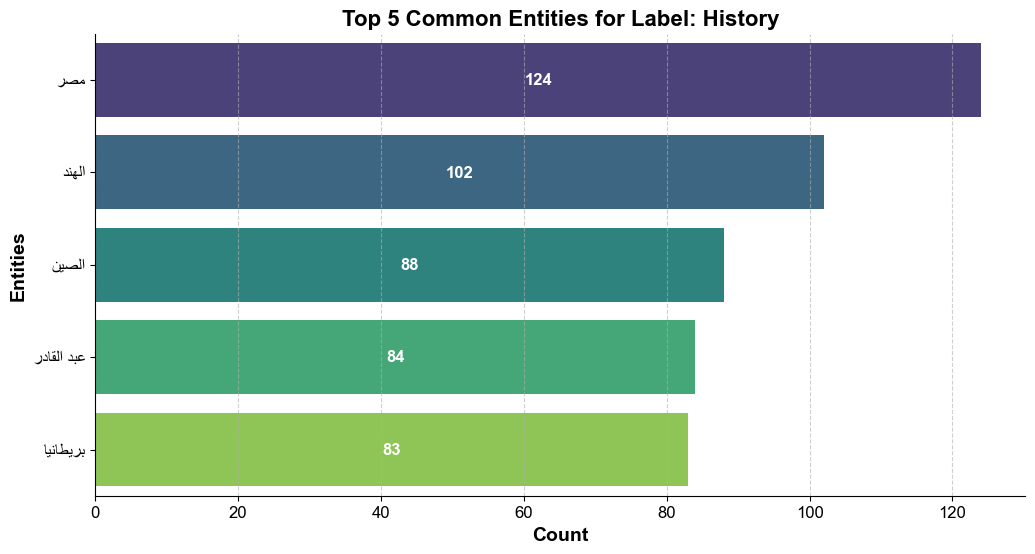

/var/folders/6h/hbprqpmn7459mqzy4s7wj5wh0000gn/T/ipykernel_17476/1319242294.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=top_entities.values, y=reshaped_entities, palette=colors)


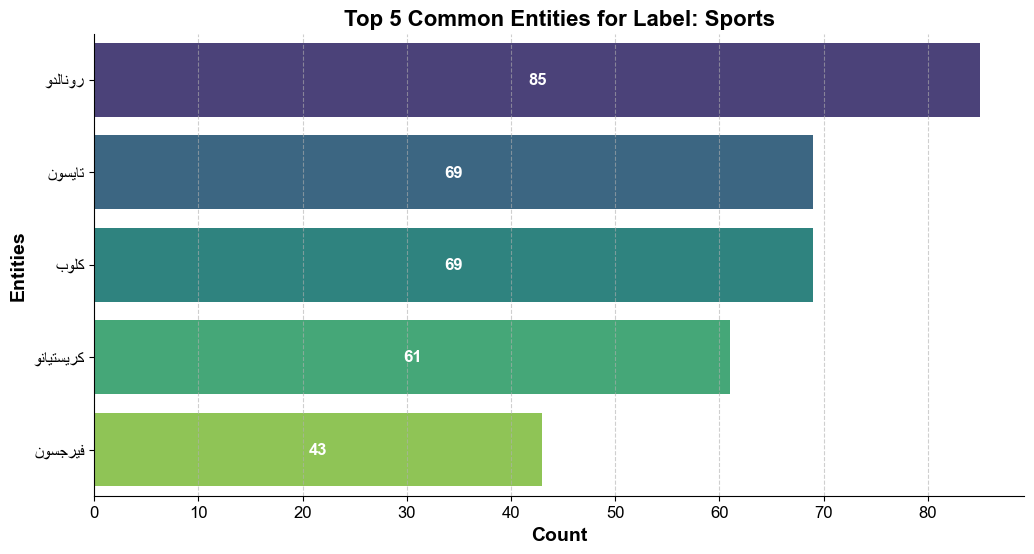

/var/folders/6h/hbprqpmn7459mqzy4s7wj5wh0000gn/T/ipykernel_17476/1319242294.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=top_entities.values, y=reshaped_entities, palette=colors)


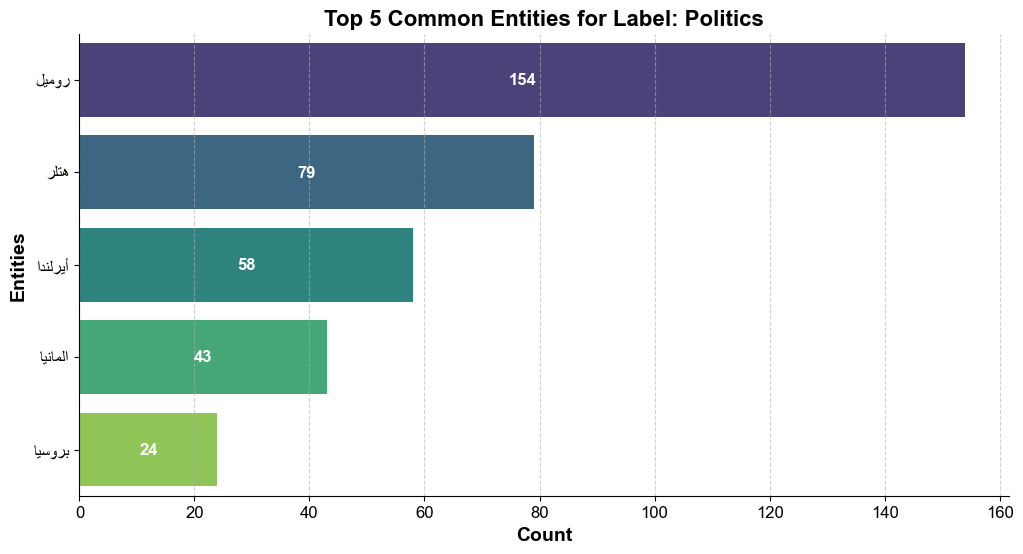

/var/folders/6h/hbprqpmn7459mqzy4s7wj5wh0000gn/T/ipykernel_17476/1319242294.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=top_entities.values, y=reshaped_entities, palette=colors)


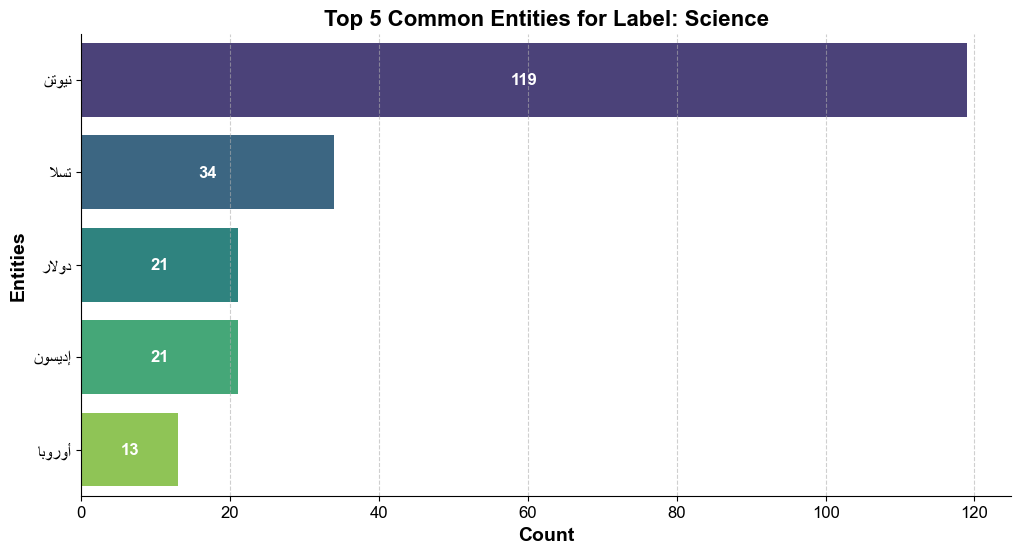

/var/folders/6h/hbprqpmn7459mqzy4s7wj5wh0000gn/T/ipykernel_17476/1319242294.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=top_entities.values, y=reshaped_entities, palette=colors)


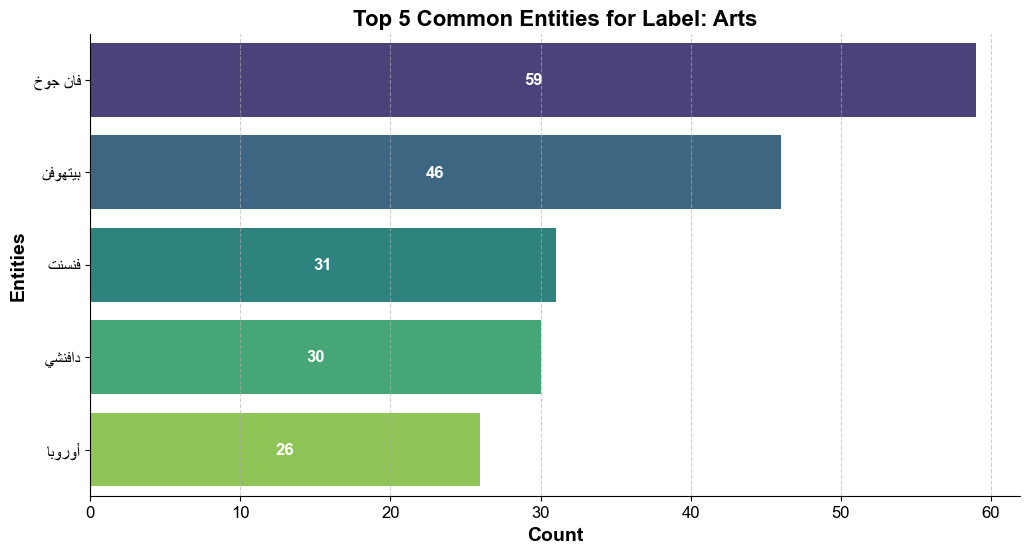

/var/folders/6h/hbprqpmn7459mqzy4s7wj5wh0000gn/T/ipykernel_17476/1319242294.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=top_entities.values, y=reshaped_entities, palette=colors)


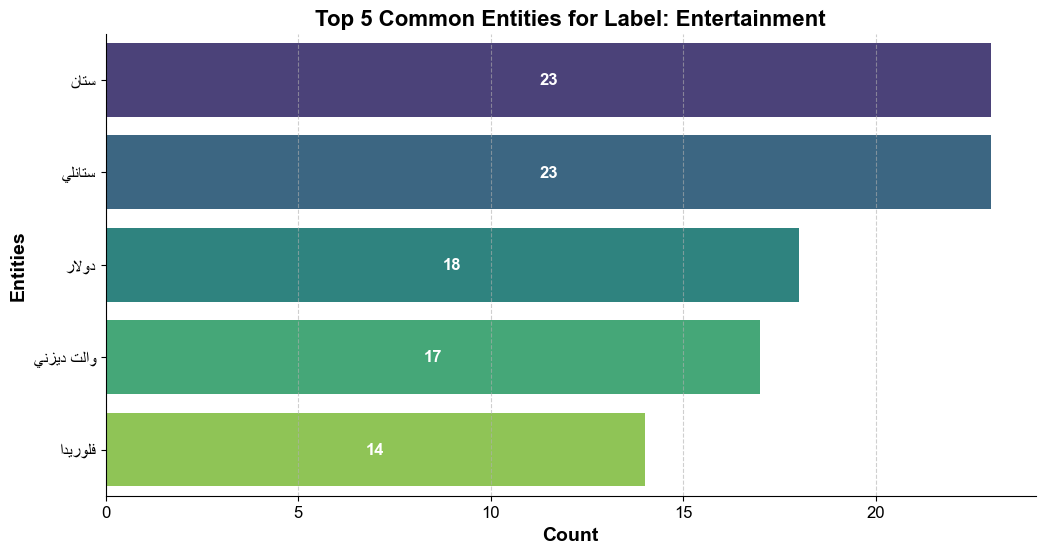

In [4]:
import arabic_reshaper
from bidi.algorithm import get_display

plt.rcParams['font.family'] = 'Arial'

# Plot the common entities for each label
top_labels = sorted(label_common_entities.keys(), key=lambda x: len(label_entities[x]), reverse=True)[:6]
print(top_labels)
for label in top_labels:
    entity_series = label_common_entities[label]
    plt.figure(figsize=(12, 6))
    top_entities = entity_series.head(5)
    reshaped_entities = [get_display(arabic_reshaper.reshape(entity)) for entity in top_entities.index]
    
    colors = sns.color_palette("viridis", len(top_entities))  # Use a gradient color scheme
    bars = sns.barplot(x=top_entities.values, y=reshaped_entities, palette=colors)
    
    plt.xlabel("Count", fontsize=14, fontweight='bold')
    plt.ylabel("Entities", fontsize=14, fontweight='bold')
    plt.title(get_display(arabic_reshaper.reshape(f"Top 5 Common Entities for Label: {label}")), fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add count labels to bars, centered inside the bars
    for bar, value in zip(bars.patches, top_entities.values):
        plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{value}', 
                 ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    sns.despine()
    plt.show()

/var/folders/6h/hbprqpmn7459mqzy4s7wj5wh0000gn/T/ipykernel_17476/1788726122.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_engagement_df["Average Engagement"], y=reshaped_labels, palette="coolwarm")


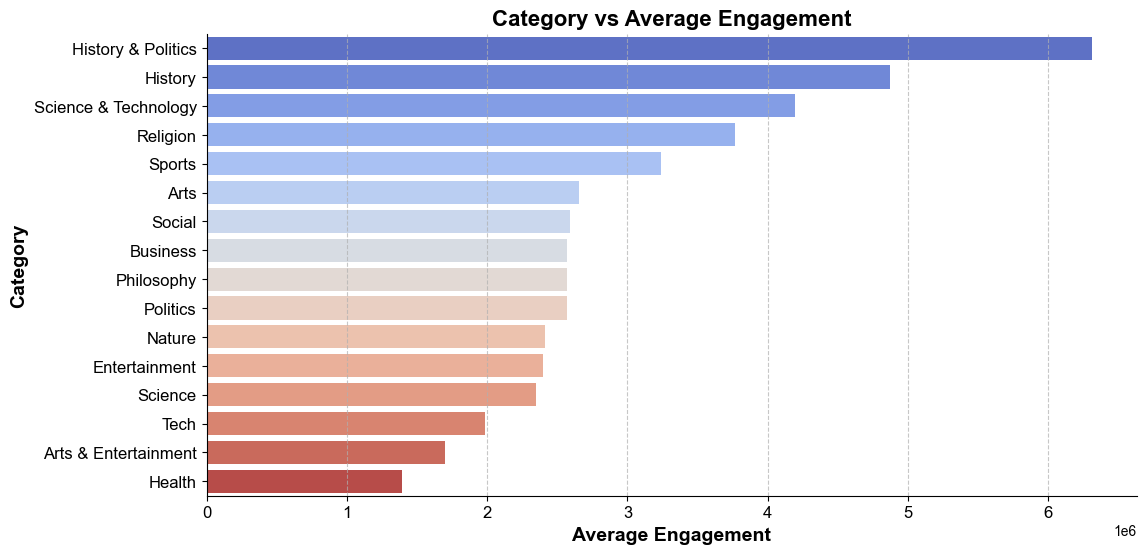

In [5]:
from collections import defaultdict

# Dictionary to store engagement by label
label_engagement = defaultdict(list)

# Process engagement data for each document based on its Label
for doc, annotation in annotations_dict.items():
    label = annotation.get("Label")
    engagement = annotation.get("Number_of_Views")
    
    if label and engagement is not None:
        label_engagement[label].append(engagement)

# Convert label vs engagement into a dataframe with average of engagement values
label_engagement_df = pd.DataFrame([(label, sum(values)/len(values)) for label, values in label_engagement.items()], columns=["Label", "Average Engagement"])
label_engagement_df = label_engagement_df.sort_values(by="Average Engagement", ascending=False)

# Plot label vs engagement with enhanced aesthetics
plt.figure(figsize=(12, 6))
reshaped_labels = [get_display(arabic_reshaper.reshape(lbl)) for lbl in label_engagement_df["Label"]]
sns.barplot(x=label_engagement_df["Average Engagement"], y=reshaped_labels, palette="coolwarm")

plt.xlabel("Average Engagement", fontsize=14, fontweight='bold')
plt.ylabel("Category", fontsize=14, fontweight='bold')
plt.title(get_display(arabic_reshaper.reshape("Category vs Average Engagement")), fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove top and right spines for a cleaner look
sns.despine()
plt.show()

/var/folders/6h/hbprqpmn7459mqzy4s7wj5wh0000gn/T/ipykernel_17476/3691187479.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=entity_series.values, y=reshaped_entities, palette=colors)


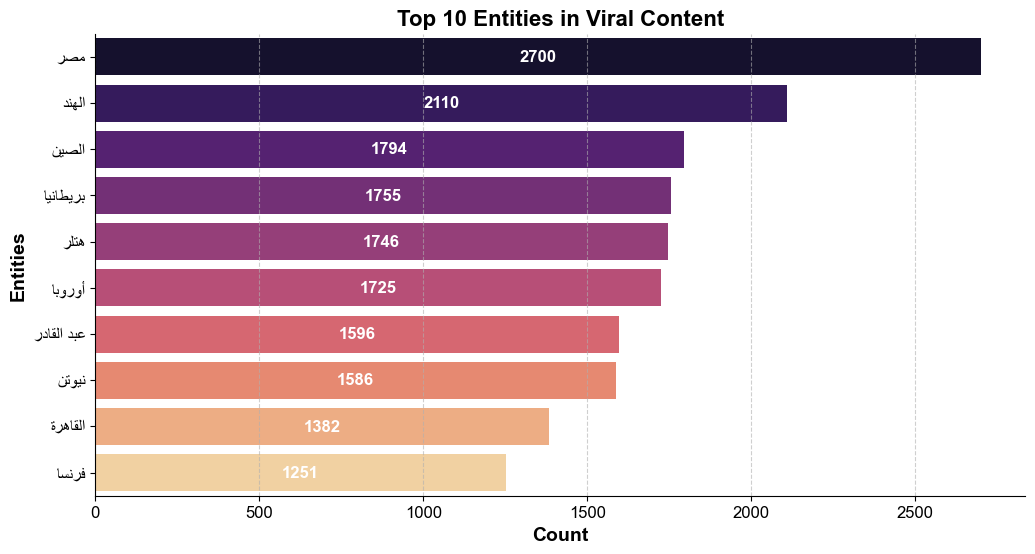

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd
import arabic_reshaper
from bidi.algorithm import get_display

# Define viral threshold based on views
viral_threshold = 1000000
viral_entities = []

# Collect entities from all viral content
for doc, annotation in annotations_dict.items():
    views = annotation.get("Number_of_Views", 0)
    
    # Check if content is viral and store entities from label_entities
    if views >= viral_threshold:
        label = annotation.get("Label")
        if label in label_entities:
            viral_entities.extend(label_entities[label])

# Compute the most common entities in viral content
entity_series = pd.Series(viral_entities).value_counts().head(10)

# Plot most common entities in viral content
plt.figure(figsize=(12, 6))
reshaped_entities = [get_display(arabic_reshaper.reshape(entity)) for entity in entity_series.index]

colors = sns.color_palette("magma", len(entity_series))  # Different color scheme
bars = sns.barplot(x=entity_series.values, y=reshaped_entities, palette=colors)

plt.xlabel("Count", fontsize=14, fontweight='bold')
plt.ylabel("Entities", fontsize=14, fontweight='bold')
plt.title(get_display(arabic_reshaper.reshape("Top 10 Entities in Viral Content")), fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add count labels to bars, centered inside the bars
for bar, value in zip(bars.patches, entity_series.values):
    plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{value}', 
             ha='center', va='center', fontsize=12, fontweight='bold', color='white')

plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine()
plt.show()

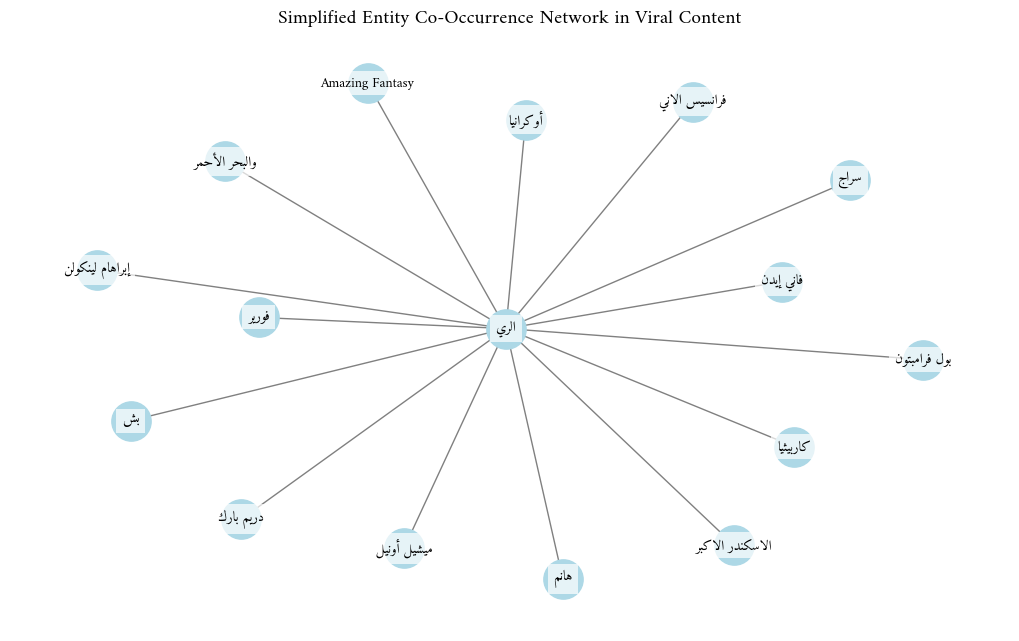

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict, Counter
import pandas as pd
import arabic_reshaper
from bidi.algorithm import get_display
from itertools import combinations
import matplotlib
import matplotlib.font_manager as fm
import os

# Specify the path to your font file
font_path = './font/Amiri-Regular.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Amiri'
plt.rcParams['font.serif'] = ['Amiri']
custom_font = fm.FontProperties(fname=font_path)

# Define viral threshold based on views
viral_threshold = 500000
viral_entities = []

# Collect entities from all viral content
for doc, annotation in annotations_dict.items():
    views = annotation.get("Number_of_Views", 0)
    
    # Check if content is viral and store entities from label_entities
    if views >= viral_threshold:
        label = annotation.get("Label")
        if label in label_entities:
            viral_entities.extend(label_entities[label])

# Generate entity co-occurrences (only most frequent)
pair_counts = Counter(combinations(set(viral_entities), 2))
common_pairs = pair_counts.most_common(15)  # Limit to top 15 for performance

# Create entity co-occurrence network
G = nx.Graph()
for (entity1, entity2), weight in common_pairs:
    G.add_edge(entity1, entity2, weight=weight)

# Draw the network graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)

# Reshape Arabic text for proper display
labels = {node: get_display(arabic_reshaper.reshape(node)) for node in G.nodes()}

# Draw network with custom font applied only once
nx.draw(G, pos, with_labels=False, node_size=800, node_color="lightblue", 
        edge_color="gray", font_size=9, font_weight="bold")

# Apply custom font to node labels without duplication
for node, (x, y) in pos.items():
    plt.text(x, y, labels[node], fontproperties=custom_font, fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title(get_display(arabic_reshaper.reshape("Simplified Entity Co-Occurrence Network in Viral Content")), 
          fontproperties=custom_font, fontsize=14, fontweight='bold')
plt.show()